# Induce More Transitions
Danny said that a higher temperature would create more activity:
> Increasing the temperature will lead to more transitions, and hence more activity in the database (see the section PARSPLICE_TASK_SEGMENT and look for Temperature and InitTemperature). Temperature at 2000 and InitTemperature at 400 should give you relatively frequent transitions. 
You can increase even more as needed.

Here we try parameters sweeps on our old cluster, which has 9 nodes each with 4 cores and 8GB of RAM. First, we define some helper functions for plotting `times.out` and the performance counters collected by our customized LevelDB version.

In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tarfile, shutil

def plot_times(results, ylim=1750):
    fig, ax = plt.subplots(len(results), 1, figsize=(4, len(results)))
    for i in range(0, len(results)):
        # ingest and plot it!
        df = pd.read_csv("../" + results[i] + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
        ax[i].plot(df["wc"], df["traj"])
    
        # labels and axes
        ax[i].set_xlim(0, ylim)
        ax[i].set_ylim(0, 20)
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([0, 10])
        ax[i].text(1.1,.5, results[i], horizontalalignment='left', transform=ax[i].transAxes)    
    
    ax[(len(results)-1)/2].set_ylabel("Trajectory (seconds)")
    ax[len(results)-1].set_xlabel("Wall Clock Time (seconds)")
    ax[len(results)-1].set_xticklabels(range(0, ylim, ylim/6))
    x = ax[0].set_title("t = Temperature, it = Initial Temperature")
    
def plot_dbactivity(results):
    fig, ax = plt.subplots(len(results), 1, figsize=(4, len(results)))
    for i in range(0, len(results)):
        # ingest and process
        try: shutil.rmtree("tmp")
        except: pass
        tar = tarfile.open("../" + results[i] + "/issdm-11/parsplice-logs.tar.gz")
        tar.extractall()
        tar.close()          
        df = pd.read_csv("tmp/parsplice-logs/perf.diff")
        write = df[(df[" name"] == " ApiWrite")]
        reads = df[(df[" name"] == " ApiGet")]
        opens = df[(df[" name"] == " ApiOpen")]    
    
        # labels and axes
        ax[i].plot(write["time"], write[" count"])
        ax[i].plot(reads["time"], reads[" count"])
        ax[i].plot(opens["time"], opens[" count"])
        ax[i].set_xticklabels([])
        ax[i].set_ylim(0, 6)
    ax[(len(results)-1)/2].set_ylabel("Datbase Reads/Writes/Opens")
    ax[len(results)-1].set_xlabel("Wall Clock Time (seconds)")
    ax[len(results)-1].set_xticklabels(range(0, 1850, 250))

## Experiment 1: Scale Temperatures Up
First we scale both temperatures up by a factor of 10, starting at a temperature of 10 and and initial temperature of 20. We run the job for 30 minutes. In the nomenclature below, `t` is temperature and `it` is initial temperature.

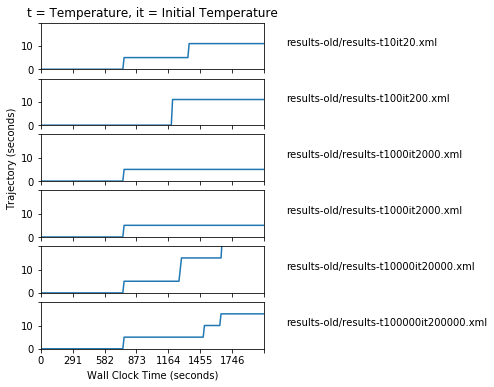

In [2]:
results = ["results-old/results-t10it20.xml",
           "results-old/results-t100it200.xml",
           "results-old/results-t1000it2000.xml",
           "results-old/results-t1000it2000.xml",
           "results-old/results-t10000it20000.xml",
           "results-old/results-t100000it200000.xml"
          ]
plot_times(results)

### Analysis
It *looks* like the higher the temperature, the more activity. But the database does not see much action. In the graphs below, we plot the writes (blue), reads (green), and opens (orange):

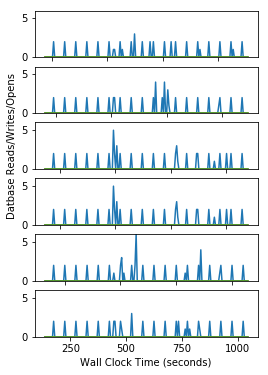

In [3]:
plot_dbactivity(results)

This does not look right. We only see writes and they are not that frequent. There is definitely not a correlation between the temperature and the number of database operations.

## Experiment 2: Fix Temperature, Scale Initial Temperature 

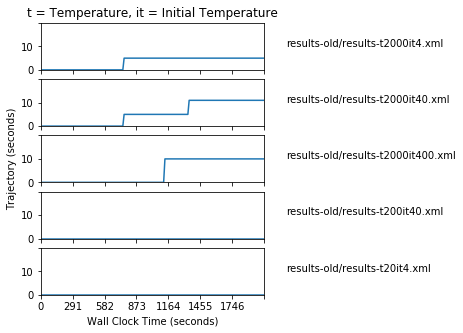

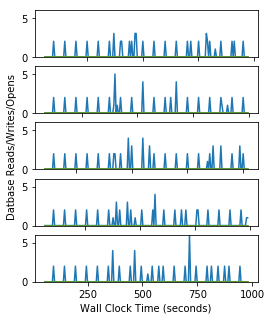

In [4]:
results = ["results-old/results-t2000it4.xml",
           "results-old/results-t2000it40.xml",
           "results-old/results-t2000it400.xml", 
           "results-old/results-t200it40.xml",
           "results-old/results-t20it4.xml"           
          ]
plot_times(results)
plot_dbactivity(results)

### Analysis
Again, we do not see a correlation and there are long periods of inactivity.

## Experiment 3: Longer Running Jobs
Next we run the job longer to see if there is more database activity in the latter stages. We run two jobs for 4 hours.

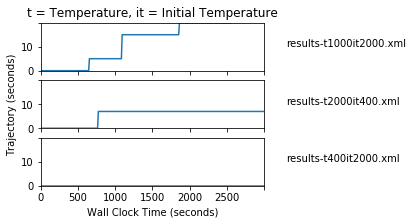

In [5]:
results = ["results-t1000it2000.xml", "results-t2000it400.xml", "results-t400it2000.xml", ]
plot_times(results, ylim=3000)